## Feature engineering

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal

from ptbxl.data.make_dataset import load_raw_data
from ptbxl.data.signal_preprocessing import SignalPreprocessing
from ptbxl.features.build_features import BuildFeatures
from ptbxl.utils.paths import (data_interim_dir, data_processed_dir,
                               data_raw_dir)

sns.set_theme()

preprocessing = SignalPreprocessing()
feature_builder = BuildFeatures()

In [3]:
# Load metatadata
dataset_metadata = pd.read_csv(data_interim_dir('dataset_metadata.csv'))
print(f'Number of records: {len(dataset_metadata)}')
display(dataset_metadata.head())

Number of records: 9553


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,max_likelihood,target
0,17,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 14:25:25,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00017_lr,records500/00000/00017_hr,AFLT,1.0
1,18,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 15:17:24,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00018_lr,records500/00000/00018_hr,AFLT,1.0
2,20,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-23 12:55:32,...,NaN,NaN,NaN,VES,NaN,9,records100/00000/00020_lr,records500/00000/00020_hr,AFLT,1.0
3,23,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-25 12:49:40,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00023_lr,records500/00000/00023_hr,AFLT,1.0
4,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,AFLT,1.0


In [4]:
# Leads names
leads = ['I', 'II', 'III', 'aVF', 'aVR', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [5]:
# Load ECG signals
fs = 100 # Sampling rate (Hz)
ecg_signals = load_raw_data(
    dataset_metadata, 
    sampling_rate=fs, 
    path=data_raw_dir('physionet.org/files/ptb-xl/1.0.3'),
)
ecg_signals = ecg_signals[:, 1*fs:-1*fs, :] # Remove first and last second

m, n, lead = ecg_signals_data_shape = ecg_signals.shape
dur = n/fs
t = np.arange(0, dur, 1/fs)

print(f'Signald block shape (m, n, lead): {ecg_signals_data_shape}')
print(f'Signals duration: {dur}')


Signald block shape (m, n, lead): (9553, 800, 12)
Signals duration: 8.0


## Preprocessing

In [6]:
ecg_signals_w0 = preprocessing.wander_removal(ecg_signals, fs, axis=1)
ecg_signals_m0 = preprocessing.mean_removal(ecg_signals_w0, axis=1)

w = int((150/1000)*fs)  # Moving average window size (150ms)
ecg_signals_pt = preprocessing.pan_tompkins(ecg_signals_m0, fs, w, axis=1)

## Dominant frequency

To compute the **dominant frequency** of a signal, we need to analyze the frequency components of the processed ECG signal, which is achieved by calculating the **Power Spectral Density (PSD)**. The dominant frequency is simply the frequency at which the PSD is maximized, representing the most significant frequency component of the signal.

Here's a step-by-step explanation of how this function computes the dominant frequency:

### Step 1: Power Spectral Density (PSD) Estimation
The function estimates the PSD using either:
1. **FFT-based periodogram** (via `signal.periodogram`), or
2. **Welch's method** (via `signal.welch`), which averages periodograms over several overlapping segments for a smoother estimate.

Let:
- $ x[n] $ represent the processed ECG signal in the time domain,
- $ f_s $ be the sampling frequency in Hz,
- $ N $ be the length of $ x[n] $.

#### Option 1: Periodogram (FFT-based PSD Estimation)
Using the periodogram method, the PSD $ P_{xx}(f) $ is estimated directly from the Fourier transform of $ x[n] $:
$$
P_{xx}(f_k) = \frac{1}{N f_s} \left| X(f_k) \right|^2 \quad \text{for } k = 0, 1, \dots, N/2
$$
where:
- $ X(f_k) $ is the Discrete Fourier Transform (DFT) of $ x[n] $ at frequency $ f_k = \frac{k f_s}{N} $.

#### Option 2: Welch's Method (Averaged Periodograms)
When using Welch's method, the signal $ x[n] $ is divided into overlapping segments, each of length $ L $ (specified by `nperseg`). The periodogram of each segment is computed, and then the periodograms are averaged to obtain a smoother PSD estimate:
$$
P_{xx}(f_k) = \frac{1}{M} \sum_{m=1}^{M} \frac{1}{L f_s} \left| X_m(f_k) \right|^2
$$
where $ M $ is the number of segments, and $ X_m(f_k) $ is the DFT of the $ m $-th segment.

### Step 2: Identify the Dominant Frequency
Once the PSD $ P_{xx}(f) $ is computed, the next step is to find the frequency at which it is maximized. This frequency is the **dominant frequency** of the signal:
$$
f_{\text{dominant}} = \arg \max_{f_k} P_{xx}(f_k)
$$
where $ f_{\text{dominant}} $ is the frequency at which $ P_{xx}(f) $ reaches its maximum value.

### Summary of the Function
- **Input**: The processed ECG signal $ x[n] $ and sampling frequency $ f_s $.
- **Output**: The dominant frequency $ f_{\text{dominant}} $, which is the frequency with the highest power in the PSD.

This dominant frequency feature can be useful in ECG analysis, as it may indicate physiological properties or the presence of artifacts in the ECG signal.

In [7]:
idx = np.random.randint(0, m)

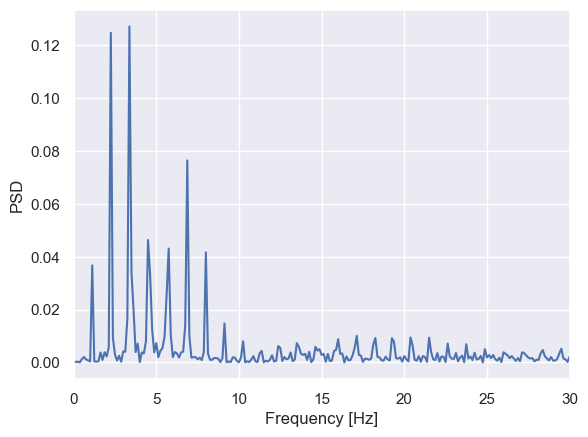

In [8]:
# Freq. content after mean removal and wander removal
x_w0 = ecg_signals_m0[idx, :, 1].ravel()
freqs, Pxx = signal.periodogram(x_w0, fs)

plt.plot(freqs, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim([0, 30])
plt.show()

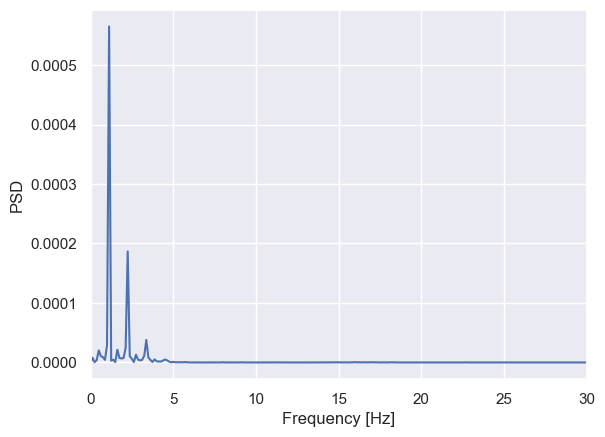

In [9]:
# Freq. content after mean removal and wander removal + PT algorithm
x_pt = ecg_signals_pt[idx, :, 1].ravel()
freqs, Pxx = signal.periodogram(x_pt, fs)

plt.plot(freqs, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim([0, 30])
plt.show()

### Compute the domint frequency to the ECG tensor

In [10]:
dominant_freq = feature_builder.dominant_frequency(
    ecg_signals_pt,
    fs=fs,
    axis=1
)

print(dominant_freq.shape)

(9553, 12)


In [11]:
df_dominant_freq = pd.DataFrame(
    dominant_freq,
    columns=['DF_' + lead for lead in leads],
    index=dataset_metadata['ecg_id'],
)
display(df_dominant_freq)

,DF_I,DF_II,DF_III,DF_aVF,DF_aVR,DF_aVL,DF_V1,DF_V2,DF_V3,DF_V4,DF_V5,DF_V6
ecg_id,,,,,,,,,,,,
17,2.375,2.375,2.375,2.375,2.375,0.125,2.375,2.375,2.375,2.375,2.375,2.375
18,2.125,2.125,0.125,2.125,2.125,0.125,2.125,2.125,2.125,2.125,2.125,2.125
20,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375
23,2.125,2.125,2.125,2.125,2.125,4.250,2.125,2.125,2.125,2.125,2.125,2.125
34,2.250,2.250,0.250,2.250,2.250,0.250,2.250,2.250,2.250,2.250,2.250,2.250
...,...,...,...,...,...,...,...,...,...,...,...,...
21830,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125
21831,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375
21834,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125,1.125


In [12]:
df_dominant_freq.to_csv(data_processed_dir('dominant_freq_dataset.csv'))

## Spectral Entropy

Spectral Entropy is a measure of the disorder or complexity within the power spectral density (PSD) of a signal, such as an ECG. It captures how energy is distributed across different frequency components, with higher entropy indicating a more uniform distribution across frequencies, and lower entropy indicating a concentration of power in specific frequency bands.

### Mathematical Definition of Spectral Entropy
Let's break down the process of calculating spectral entropy for an ECG signal:

1. **Compute the Power Spectral Density (PSD)**:
   - First, calculate the PSD of the ECG signal to determine the power at each frequency component. This can be done using the **Fast Fourier Transform (FFT)** or **Welch's method**.
   - Let $ P(f) $ represent the PSD of the signal at frequency $ f $. The sum of $ P(f) $ over all frequencies should equal 1 to normalize it, so we define:
     $$
     p(f) = \frac{P(f)}{\sum_{f} P(f)}
     $$
   where $ p(f) $ represents the normalized power at each frequency.

2. **Calculate Spectral Entropy**:
   - Spectral entropy is computed as the **Shannon entropy** of the normalized power distribution $ p(f) $:
     $$
     H_{\text{spectral}} = -\sum_{f} p(f) \log(p(f))
     $$
   - This value represents the **spectral entropy**, with higher values indicating a more spread-out, complex frequency distribution and lower values indicating more concentrated power in certain frequency bands.

### Interpretation of Spectral Entropy in ECG Signals
In ECG analysis, spectral entropy can be a useful feature because it provides insight into the **frequency content and regularity** of the signal:
- **Lower Spectral Entropy**: Indicates a more regular and periodic signal, where most power is concentrated at a few dominant frequencies (e.g., during normal sinus rhythm).
- **Higher Spectral Entropy**: Suggests a more irregular or complex signal with a broader frequency distribution, which may be associated with arrhythmias or other abnormalities.

### Utility of Spectral Entropy as a Feature
Spectral entropy can be a valuable feature in ECG classification and diagnosis because it quantifies the **complexity of the ECG signal** in the frequency domain. Here's how it can be useful:
- **Arrhythmia Detection**: Abnormal rhythms often have irregular frequency distributions, which can increase spectral entropy. For example, atrial fibrillation tends to have higher spectral entropy compared to regular sinus rhythm.
- **Heart Rate Variability Analysis**: Variability in heart rate leads to changes in spectral entropy, which can be useful in stress or autonomic function studies.
- **General Classification**: In machine learning models, spectral entropy can serve as an important feature, helping distinguish between normal and abnormal ECG patterns by adding a quantitative measure of frequency distribution.

### Pros and Cons of Using Spectral Entropy
- **Pros**:
  - Provides a compact representation of frequency complexity.
  - Effective at distinguishing between regular and irregular ECG patterns.
  - Simple to calculate and interpret.
  
- **Cons**:
  - Sensitive to noise, which can artificially inflate entropy.
  - May not capture all relevant ECG dynamics if used alone.

### Summary
Spectral entropy is a useful feature for ECG analysis as it captures the complexity of the frequency distribution. It can be used effectively in applications like arrhythmia detection, heart rate variability studies, and general ECG classification tasks.

### Compute the spectral entropy of the ECG tensor

In [13]:
spectral_entropy = feature_builder.spectral_entropy(
    ecg_signals_pt,
    fs=fs,
    axis=1
)

print(spectral_entropy.shape)

(9553, 12)


In [14]:
df_spectral_entropy = pd.DataFrame(
    spectral_entropy,
    columns=['SpecEn_' + lead for lead in leads],
    index=dataset_metadata['ecg_id']
)
display(df_spectral_entropy)

,SpecEn_I,SpecEn_II,SpecEn_III,SpecEn_aVF,SpecEn_aVR,SpecEn_aVL,SpecEn_V1,SpecEn_V2,SpecEn_V3,SpecEn_V4,SpecEn_V5,SpecEn_V6
ecg_id,,,,,,,,,,,,
17,3.289557,4.353171,2.972657,3.605055,3.073835,3.973401,3.177757,2.976148,3.218329,3.352363,3.583782,3.776226
18,3.588119,4.318525,4.584895,3.885498,3.535618,4.669299,3.690409,3.746803,3.724861,3.534203,3.702033,3.747163
20,2.204227,2.678269,2.404655,2.342829,2.066037,3.824168,2.351758,2.354900,2.420131,2.668788,2.961126,2.957242
23,1.041174,1.671122,2.210916,1.062937,1.191253,4.776656,1.103997,1.203116,1.052893,1.235478,1.542783,1.553533
34,2.755370,2.556874,4.823949,2.600263,3.068497,4.287855,2.643821,2.738881,2.966505,2.729826,2.628228,2.534884
...,...,...,...,...,...,...,...,...,...,...,...,...
21830,3.711034,3.600087,3.720669,3.638128,3.839030,3.748879,3.516415,3.421014,2.867906,3.705543,3.555182,3.626356
21831,3.635561,3.497683,4.127409,3.573176,3.751020,3.435811,3.180557,3.723080,3.754674,3.791147,3.682367,3.570465
21834,2.321258,2.308685,2.425151,2.306123,2.342697,2.620379,2.165620,2.320835,2.534459,2.727189,2.722512,2.396305


In [15]:
df_spectral_entropy.to_csv(data_processed_dir('spec_entropy_dataset.csv'))

## Wavelet based features

Wavelet analysis is a powerful technique for time-frequency analysis, which makes it particularly well-suited for extracting features from ECG signals. It provides localized information about both the frequency and time components of a signal, making it ideal for handling the non-stationary nature of ECG data

The **Wavelet Transform (WT)** decomposes a signal into scaled and shifted versions of a wavelet function, providing both time and frequency resolution. For ECG, this allows you to capture transient features like QRS complexes, P waves, and T waves at different frequency scales.

### Types of Wavelet Transforms:
1. **Continuous Wavelet Transform (CWT)**:
   - Produces a time-frequency representation by convolving the signal with wavelet functions at various scales and translations.
   - More detailed but computationally intensive.
2. **Discrete Wavelet Transform (DWT)**:
   - Decomposes the signal into discrete frequency bands using scaling and wavelet functions.
   - Commonly used for feature extraction due to computational efficiency.

### Extracting Wavelet Features

The **DWT** can be used to decompose the signal into multiple levels of approximation (low-frequency components) and detail coefficients (high-frequency components). It requires the selection of a **mother wavelet** (e.g., `db4` or `sym5`) based on the signal's characteristics. For ECG, `db4` is a popular choice. From the wavelet coefficients, we can extract features such as:

1. **Energy in Sub-bands**:
   - Compute the energy of each approximation and detail coefficient.
     $$
     E_k = \sum_{i} |c_k[i]|^2
     $$
     where $ c_k[i] $ are the wavelet coefficients at level $ k $.
2. **Entropy**:
   - Compute the Shannon entropy of wavelet coefficients to quantify their irregularity:
     $$
     H_k = -\sum_{i} p_k[i] \log(p_k[i])
     $$
     where $ p_k[i] $ is the normalized energy of the coefficients.
3. **Statistical Features**:
   - Mean, variance, skewness, and kurtosis of the coefficients.
4. **Dominant Wavelet Coefficient**:
   - Find the coefficient with the maximum magnitude in each sub-band.

In [16]:
wavelet_based_features = feature_builder.wavelet_fetures(
    ecg_signals_pt,
    wavelet='db4',
    level=4,
    axis=1
)

In [17]:
df_wavelet_based_features_list = []
for level_features in wavelet_based_features:
    for key, item in level_features.items():
        
        df_wavelet_based_features_list.append(
            pd.DataFrame(
                item,
                columns=[f'{key}_' + lead for lead in leads],
                index=dataset_metadata['ecg_id']
            )
        )

df_wavelet_based_features = pd.concat(df_wavelet_based_features_list, axis=1)
display(df_wavelet_based_features)


,l1nrg_I,l1nrg_II,l1nrg_III,l1nrg_aVF,l1nrg_aVR,l1nrg_aVL,l1nrg_V1,l1nrg_V2,l1nrg_V3,l1nrg_V4,...,l5std_III,l5std_aVF,l5std_aVR,l5std_aVL,l5std_V1,l5std_V2,l5std_V3,l5std_V4,l5std_V5,l5std_V6
ecg_id,,,,,,,,,,,,,,,,,,,,,
17,0.011950,0.000786,0.003699,0.002877,0.006016,0.000339,0.010135,0.461388,0.220560,0.041010,...,0.000066,0.000084,0.000099,0.000018,0.000145,0.000936,0.000680,0.000332,0.000352,0.000266
18,0.008544,0.003087,0.000763,0.004589,0.001994,0.000376,0.006469,0.621842,0.183716,0.045207,...,0.000031,0.000095,0.000061,0.000021,0.000120,0.001020,0.000610,0.000335,0.000366,0.000259
20,0.013791,0.002031,0.001211,0.005277,0.004089,0.000199,0.004981,0.281549,0.029084,0.018568,...,0.000038,0.000105,0.000084,0.000014,0.000107,0.000743,0.000260,0.000218,0.000191,0.000169
23,0.009302,0.001365,0.001194,0.003384,0.003036,0.000236,0.005268,0.242416,0.033574,0.014882,...,0.000037,0.000094,0.000071,0.000018,0.000097,0.000675,0.000274,0.000205,0.000226,0.000156
34,0.016668,0.008425,0.000441,0.011098,0.002562,0.000687,0.002719,0.205755,0.011381,0.012004,...,0.000025,0.000142,0.000077,0.000030,0.000089,0.000641,0.000158,0.000154,0.000119,0.000136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21830,0.000215,0.000188,0.000002,0.000192,0.000021,0.000016,0.000234,0.003870,0.004394,0.141736,...,0.000002,0.000018,0.000007,0.000004,0.000020,0.000084,0.000085,0.000546,0.000350,0.000152
21831,0.004495,0.002329,0.000004,0.003266,0.000506,0.000072,0.003748,0.004910,0.063014,0.019067,...,0.000002,0.000052,0.000020,0.000008,0.000066,0.000067,0.000226,0.000122,0.000081,0.000073
21834,0.002490,0.000396,0.000167,0.001004,0.000692,0.000014,0.002957,0.050908,0.043999,0.068480,...,0.000013,0.000038,0.000030,0.000004,0.000059,0.000222,0.000187,0.000220,0.000182,0.000105


In [18]:
df_wavelet_based_features.to_csv(data_processed_dir('wave_dec_dataset.csv'))